## FasterRCNN dataset and EDA

In [ ]:
import os
from PIL import Image
import numpy as np
import torch
import torchvision
from tqdm.notebook import tqdm
import glob
import json
import pandas as pd

### Dataset

In [ ]:
class RoadSignDataset(Dataset):
    def __init__(self, root, annotations_file, transform=None):
        self.root = root
        self.transform = transform
        with open(annotations_file) as f:
            self.annotations = json.load(f)
        self.images = self.annotations['images']
        self.labels = self.annotations['annotations']
        self.transforms = transform


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_id = img_info['id']  
        img_path = os.path.join(self.root, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        boxes = []
        labels = []
        area = []
        iscrowd = []
        for label in self.labels:
            if label['image_id'] == img_id:
                x_min, y_min, width, height = label['bbox']
                x_max = x_min + width
                y_max = y_min + height
                if x_max > x_min and y_max > y_min:
                    corrected_bbox = [x_min, y_min, x_max, y_max]
                    boxes.append(corrected_bbox)
                    labels.append(label['category_id'])
                    area.append(label['area'])
                    iscrowd.append(label['iscrowd'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target["image_id"] = img_id
        target["iscrowd"] = iscrowd
        target["area"] = area



        return image, target


### Utils

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_annotation(annotation, images, path_to_dataset='/kaggle/input/rtsd-dataset/rtsd-frames'):
    filename = None
    for img in images:
        if img['id'] == annotation['image_id']:
            filename = img['file_name']
            break
    
    img_path = os.path.join(path_to_dataset, filename)
    image = Image.open(img_path).convert("RGB")
    
    # show image with box
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    x_min, y_min, width, height = annotation['bbox']
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

def show_image_with_boxes(dataset, idx):
    image, target = dataset[idx]
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for box in target['boxes']:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

In [ ]:
path_to_dataset = '/kaggle/input/rtsd-dataset'
annotations_file = f'{path_to_dataset}/train_anno.json'

dataset = RoadSignDataset(root=f'{path_to_dataset}/rtsd-frames',
                          annotations_file=annotations_file)
with open(annotations_file, 'r', encoding='utf-8') as file:
    json_data = json.load(file)

print(f"train_dataset size: {len(dataset)}")
print(f"all signs: {len(json_data['annotations'])}")

show_image_with_boxes(dataset, 10)
show_annotation(json_data['annotations'][19], json_data['images'])

In [ ]:
label_map_file = '/kaggle/input/rtsd-dataset/label_map.json'
with open(label_map_file) as f:
    label_map = json.load(f)
id2label = {v: k for k, v in label_map.items()}

In [ ]:
df = pd.DataFrame(json_data['annotations'])
df['sign_name'] = df['category_id'].map(id2label)
df['global_group'] = df['sign_name'].apply(lambda x: x.split('_')[0])

### EDA

In [ ]:
agg_func_count = {'sign_name': ['count', 'nunique']}
df.groupby(['global_group']).agg(agg_func_count)

In [ ]:
def get_info_group(df, group: str, min_area: int, show_diagram=True):
    group_val_count = df[(df['global_group'] == group) & (df['area'] >= min_area)]['sign_name'].value_counts()
    
    print(f'Всего уникальных знаков в группе №{group}: {len(group_val_count.keys())}')
    print(f'Общее количество знаков в группе №{group}: {sum(group_val_count.values)}')
    
    if show_diagram:
        group_val_count.plot(kind='barh')
        plt.title(f'Группа знаков №{group}')
        plt.show()

In [ ]:
samples_per_class = 100
balanced_data = []

# Итерация по каждому классу
for class_id in df['category_id'].unique():
    class_data = df[df['category_id'] == class_id]
    sample = class_data.sample(min(samples_per_class, len(class_data)), replace=False)
    balanced_data.append(sample)

# Создание нового сбалансированного датасета
balanced_df = pd.concat(balanced_data)


In [ ]:
for group in balanced_df['global_group'].unique():
    get_info_group(balanced_df, group=group, min_area=0, show_diagram=True)

In [ ]:
# balanced_df[['id', 'image_id', 'category_id', 'area', 'bbox', 'iscrowd']].to_json('train_min100per_class.json')

In [ ]:
balanced_df[['id']].to_csv('train_id_anno_100per_class.csv', index=False)

### Группа 2. Знаки приоритета

In [ ]:
group = '2'
get_info_group(df, group)

Смотрим на элементы группы 2

In [ ]:
df[(df['global_group'] == group) & (df['area'] > 3000)].groupby('sign_name').first()

In [ ]:
first_all_2 = df[(df['global_group'] == group) & (df['area'] > 2000)].groupby('sign_name').first()
ids = first_all_2['image_id'].to_list()
bbox = first_all_2['bbox'].to_list()

for i in range(len(ids)):
    print(first_all_2.index[i])
    show_image_with_box(annotations['images'], ids[i], bbox[i])

Не хватает 2.3.6 и 2.3.7
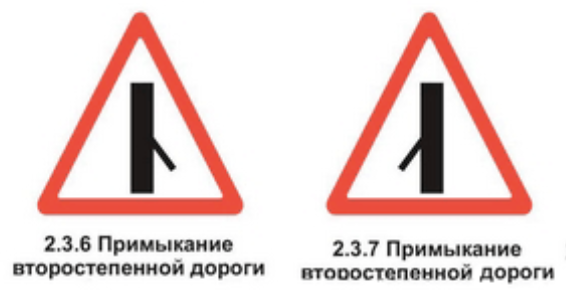

In [ ]:
df['sign_name'] = df['sign_name'].apply(lambda x: '2_3' if '2_3' in x else x)

In [ ]:
df[df['global_group'] == '2']['sign_name'].value_counts()

In [ ]:
# unique_sign_names = df['sign_name'].unique()
# mapping_dict = {sign_name: df[df['sign_name'] == sign_name]['category_id'].iloc[0] for sign_name in unique_sign_names}